In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
#print(torch.cuda.current_device())
#print(torch.cuda.get_device_name(torch.cuda.current_device()))
if(torch.cuda.is_available()):
 device = torch.device('cuda:0')
else:
 device = torch.device('cpu')

False
0


In [3]:
df = pd.read_csv('results/results_100_10000.csv', header=None)
model_num = 1
# display(df)
results = df.to_numpy()
print(results.shape)
print(results[:,-1].shape)
X = torch.tensor(results[:,:-1]).to(torch.float32).to(device)
if model_num == 1:
    X = torch.reshape(X,(X.shape[0],1,10,10))
y = torch.tensor(np.expand_dims(results[:,-1], axis=1)).to(torch.float32).to(device)
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, y_train.shape)
# Setting up Dataloader
# training_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(training_dataset, batch_size=24, shuffle=True)

(10000, 101)
(10000,)
torch.Size([10000, 1, 10, 10]) torch.Size([10000, 1])
torch.Size([6700, 1, 10, 10]) torch.Size([6700, 1])


In [4]:
input_size = X.shape[1]
if model_num == 0:
    model = nn.Sequential(nn.Linear(input_size, 64),
                        nn.ReLU(),
                        nn.Linear(64,32),
                        nn.ReLU(),
                        nn.Linear(32,32),
                        nn.BatchNorm2d(),
                        nn.ReLU(),
                        nn.Linear(32, 1),
                        nn.Sigmoid())
else:
    model = nn.Sequential(nn.Conv2d(1,64,2),
                          nn.ReLU(),
                          nn.BatchNorm2d(num_features=64),
                          nn.Conv2d(64,32,3),
                          nn.ReLU(),
                          nn.BatchNorm2d(num_features=32),
                          nn.Flatten(),
                          nn.Linear(1568, 30),
                          nn.ReLU(),
                          nn.Linear(30, 15),
                          nn.ReLU(),
                          nn.Linear(15,1),
                          nn.Sigmoid())
model.to(device)
print(model)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1568, out_features=30, bias=True)
  (8): ReLU()
  (9): Linear(in_features=30, out_features=15, bias=True)
  (10): ReLU()
  (11): Linear(in_features=15, out_features=1, bias=True)
  (12): Sigmoid()
)


In [5]:
loss_function = nn.MSELoss()
# loss_function = nn.BCELoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
losses = []

In [6]:
import time

start_time = time.time()
save_interval = 10
best_loss = float('inf')
file_path = 'model_checkpoint.pt'

epochs = 300
for epoch in range(epochs):
  y_pred = model(X_train)
  #y_pred = model(X_test)

  loss = loss_function(y_pred, y_train)
  #loss = loss_function(y_pred, y_test)
  
  losses.append(loss.item())
  
  model.zero_grad()
  loss.backward()
  
  optimizer.step()
  
  #Indicates what epoch it is on
  if(epoch % 10 == 0):
      elapsed_time = time.time() - start_time
      print("Epoch: {}, Elapsed Time: {:.2f} seconds".format(epoch+1, elapsed_time))
        
  #Once we are at an epoch past 300
  #We will test our model using the testing data.
  if(epoch > 10 and epoch % save_interval == 0):
    y_pred_test = model(X_test)
    test_loss = loss_function(y_pred_test, y_test)

    #Used to get the best loss
    if(test_loss.item() < best_loss):
      state = {'epoch': epoch,'loss': test_loss}
      #'state_dict': model.state_dict(),
      # 'optimizer': optimizer.state_dict(),
      torch.save(state,file_path)
      best_loss = test_loss.item()
  

Epoch: 1, Elapsed Time: 1.26 seconds
Epoch: 11, Elapsed Time: 13.03 seconds
Epoch: 21, Elapsed Time: 25.26 seconds
Epoch: 31, Elapsed Time: 36.72 seconds
Epoch: 41, Elapsed Time: 48.79 seconds
Epoch: 51, Elapsed Time: 60.27 seconds
Epoch: 61, Elapsed Time: 71.44 seconds
Epoch: 71, Elapsed Time: 82.64 seconds
Epoch: 81, Elapsed Time: 93.92 seconds
Epoch: 91, Elapsed Time: 105.08 seconds
Epoch: 101, Elapsed Time: 116.24 seconds
Epoch: 111, Elapsed Time: 127.44 seconds
Epoch: 121, Elapsed Time: 139.64 seconds
Epoch: 131, Elapsed Time: 151.51 seconds
Epoch: 141, Elapsed Time: 162.89 seconds
Epoch: 151, Elapsed Time: 173.95 seconds
Epoch: 161, Elapsed Time: 185.10 seconds
Epoch: 171, Elapsed Time: 196.16 seconds
Epoch: 181, Elapsed Time: 207.31 seconds
Epoch: 191, Elapsed Time: 218.51 seconds
Epoch: 201, Elapsed Time: 229.79 seconds
Epoch: 211, Elapsed Time: 240.95 seconds
Epoch: 221, Elapsed Time: 252.21 seconds
Epoch: 231, Elapsed Time: 263.30 seconds
Epoch: 241, Elapsed Time: 274.44 seco

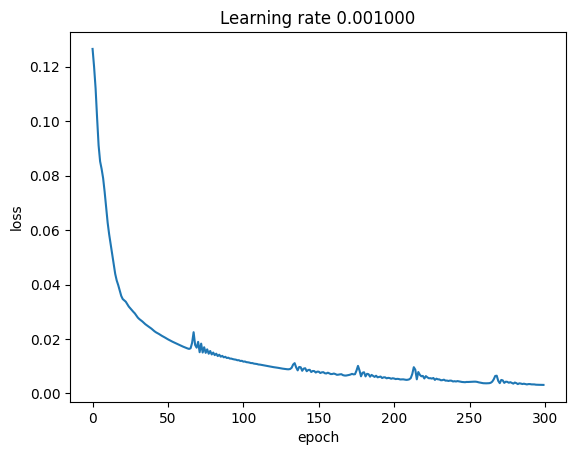

180
0.018339313566684723


In [7]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

checkpoint = torch.load(file_path)
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
best_loss = checkpoint['loss']

print(epoch)
print(best_loss.item())



In [8]:
y_pred = model(X_test)
loss = loss_function(y_pred, y_test)
print(loss.item())
compiled_results = y_test.cpu().detach().numpy()
compiled_results = np.append(compiled_results, y_pred.cpu().detach().numpy(), axis=1)
results = pd.DataFrame(compiled_results, columns = ['y_test','y_pred'])
pd.set_option('display.max_rows', 30)
display(results)

0.01884324476122856


,y_test,y_pred
0,0.17,0.234018
1,0.93,0.888441
2,0.88,0.669729
3,0.60,0.579638
4,0.01,0.034620
...,...,...
3295,0.01,0.072909
3296,0.26,0.314231
3297,0.91,0.960265
3298,0.46,0.377340
